In [1]:
%matplotlib inline

In [13]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## 2017-11-21

First experiments

### Generate some data in $\mathbb{R}^3$

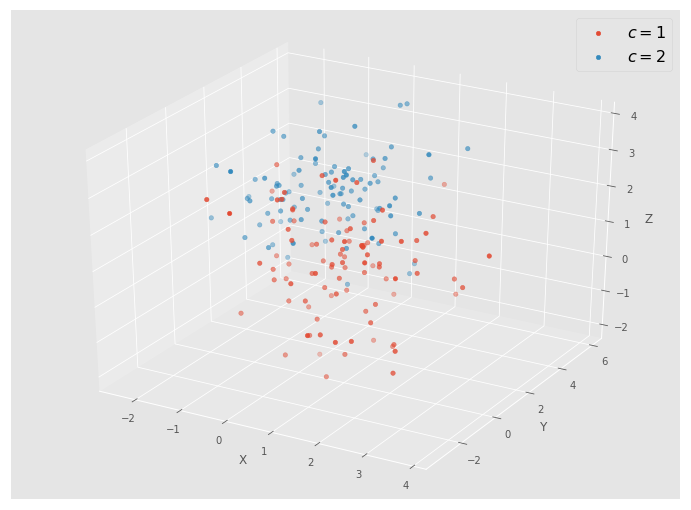

In [15]:
np.random.seed(RANDOM_SEED)

FIRST_MEAN = np.asarray([1, 0, 1])
FIRST_COV = np.eye(3) * np.random.uniform(0.5, 2.5, 3)

SECOND_MEAN = np.asarray([0, 2, 2])
SECOND_COV = np.eye(3) * np.random.uniform(0.5, 2.5, 3)

N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_class[:, 0], first_class[:, 1], first_class[:, 2], label='$c=1$')
ax.scatter(second_class[:, 0], second_class[:, 1], second_class[:, 2], label='$c=2$')
ax.legend(loc='best', fontsize=16)
ax.set_xlabel('X', size=12)
ax.set_ylabel('Y', size=12)
ax.set_zlabel('Z', size=12)

### Join data to build a test set, run LDA, visualize

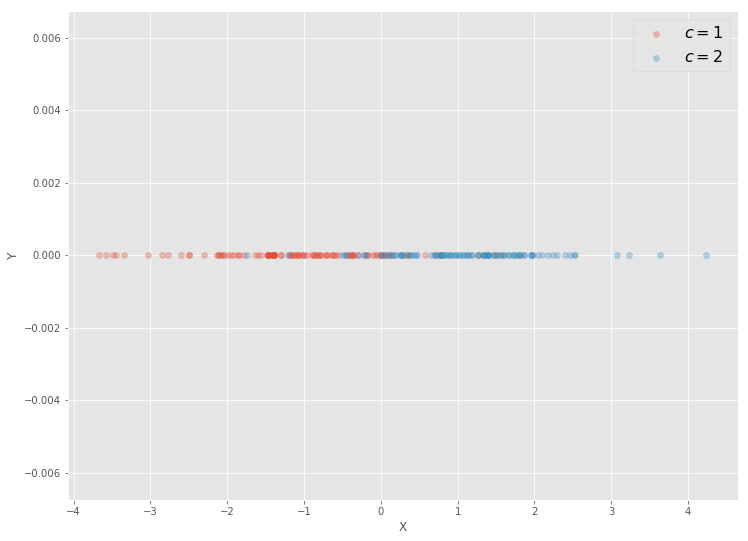

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = np.vstack([first_class, second_class])
y = np.asarray([1] * 100 + [2] * 100)

lda = LinearDiscriminantAnalysis(n_components=1)
transformed_X = lda.fit_transform(X, y)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111) #, projection='3d')
ax.scatter(transformed_X[:100], [0] * 100, label='$c=1$', alpha=0.33)
ax.scatter(transformed_X[100:], [0] * 100, label='$c=2$', alpha=0.33)
ax.legend(loc='best', fontsize=16)
ax.set_xlabel('X', size=12)
ax.set_ylabel('Y', size=12)

(200, 3)